# Feature Engineering 

I do a bit of feature engineering in this notebook.

A lot our raw data won't work well directly with machine learning models.

One big problem is how the current representation of time of day time of day in our dataset. If we feed raw time into the model, it will think 11:59 PM (2359) and Midnight (0000) are wildly different times of day.

It would be nice to do some feature engineering to make our time data more representitive of its true nature (Cyclic).

In [39]:
import pandas as pd
DATA_PATH = '../data/raw/jan_2025_ontime.csv'
df = pd.read_csv(DATA_PATH)

# 2. The Cleaning Logic (From Notebook 01)
# Drop missing targets
df_clean = df.dropna(subset=['ARR_DELAY']).reset_index(drop=True)
df_clean = df_clean.drop(columns=['CANCELLED', 'DIVERTED'])

In [40]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522269 entries, 0 to 522268
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   YEAR               522269 non-null  int64  
 1   MONTH              522269 non-null  int64  
 2   DAY_OF_MONTH       522269 non-null  int64  
 3   DAY_OF_WEEK        522269 non-null  int64  
 4   OP_UNIQUE_CARRIER  522269 non-null  object 
 5   ORIGIN_AIRPORT_ID  522269 non-null  int64  
 6   ORIGIN             522269 non-null  object 
 7   DEST_AIRPORT_ID    522269 non-null  int64  
 8   DEST               522269 non-null  object 
 9   CRS_DEP_TIME       522269 non-null  int64  
 10  DEP_DELAY          522269 non-null  float64
 11  DEP_DEL15          522269 non-null  float64
 12  CRS_ARR_TIME       522269 non-null  int64  
 13  ARR_DELAY          522269 non-null  float64
 14  ARR_DEL15          522269 non-null  float64
 15  DISTANCE           522269 non-null  float64
dtypes:

In [54]:
# Look at the max and min times
print(f"Earliest Scheduled Departure Time: {df_clean['CRS_DEP_TIME'].min()}")
print(f"Latest Scheduled Departure Time:   {df_clean['CRS_DEP_TIME'].max()}")

# Imagine a flight at 2359 and a flight at 0005.
# Mathematical difference:
diff = 2359 - 5
print(f"Math thinks the difference is: {diff}")
print("Reality: The difference is 6 minutes.")

Earliest Scheduled Departure Time: 5
Latest Scheduled Departure Time:   2359
Math thinks the difference is: 2354
Reality: The difference is 6 minutes.


In [42]:
# Cell 3: Convert HHMM to Total Minutes
# We create a helper function to keep things clean
def convert_to_minutes(df, col_name):
    """
    Takes a column in HHMM format (integer) and returns minutes since midnight.
    """
    # Floor division (//) gets the hour
    hours = df[col_name] // 100
    
    # Modulo (%) gets the remaining minutes
    minutes = df[col_name] % 100
    
    # Calculate total minutes
    total_minutes = (hours * 60) + minutes
    return total_minutes

# Apply it to Departure and Arrival
df_clean['dep_minutes'] = convert_to_minutes(df_clean, 'CRS_DEP_TIME')
df_clean['arr_minutes'] = convert_to_minutes(df_clean, 'CRS_ARR_TIME')

# VERIFICATION
# Let's check the logic on a specific time, e.g., 2:30 PM (1430)
test_case = df_clean[df_clean['CRS_DEP_TIME'] == 1430].head()
print("Test Case (1430 -> 870?):")
print(test_case[['CRS_DEP_TIME', 'dep_minutes']])

Test Case (1430 -> 870?):
      CRS_DEP_TIME  dep_minutes
385           1430          870
563           1430          870
779           1430          870
1004          1430          870
1032          1430          870


## When you hear cyclic think trigonometry! (sin and cosine)

In [43]:
# Cell 4: Cyclic Encoding (Time + Date)

def create_cyclic_features(df, col_name, total_period):
    """
    Creates Sin and Cos features for a cyclic variable.
    """
    radians = (df[col_name] / total_period) * 2 * np.pi
    sin_feat = np.sin(radians)
    cos_feat = np.cos(radians)
    return sin_feat, cos_feat

# 1. Time (Period = 1440 minutes)
df_clean['dep_sin'], df_clean['dep_cos'] = create_cyclic_features(df_clean, 'dep_minutes', 1440)
df_clean['arr_sin'], df_clean['arr_cos'] = create_cyclic_features(df_clean, 'arr_minutes', 1440)

# 2. Day of Month (Period = 31 days)
# This captures that the end of the month flows into the start of the next
df_clean['day_sin'], df_clean['day_cos'] = create_cyclic_features(df_clean, 'DAY_OF_MONTH', 31)

print("Cyclic Features Created: Time and Day of Month.")
print(df_clean[['DAY_OF_MONTH', 'day_sin', 'day_cos']].head())

Cyclic Features Created: Time and Day of Month.
   DAY_OF_MONTH   day_sin  day_cos
0             1  0.201299  0.97953
1             1  0.201299  0.97953
2             1  0.201299  0.97953
3             1  0.201299  0.97953
4             1  0.201299  0.97953


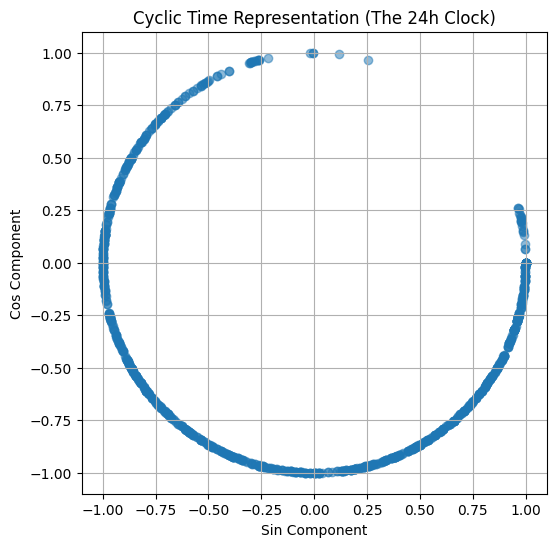

In [44]:
# Cell 5: Visualize the Clock
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Plot a sample of 1000 points to save rendering time
sample = df_clean.sample(1000)

plt.scatter(sample['dep_sin'], sample['dep_cos'], alpha=0.5)

plt.title("Cyclic Time Representation (The 24h Clock)")
plt.xlabel("Sin Component")
plt.ylabel("Cos Component")
plt.grid(True)

plt.show()

In [45]:
df

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,CRS_DEP_TIME,DEP_DELAY,DEP_DEL15,CRS_ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
0,2025,1,1,3,AA,10140,ABQ,11298,DFW,500,-8.0,0.0,754,-21.0,0.0,0.0,0.0,569.0
1,2025,1,1,3,AA,10140,ABQ,11298,DFW,555,-3.0,0.0,849,-17.0,0.0,0.0,0.0,569.0
2,2025,1,1,3,AA,10140,ABQ,11298,DFW,820,-5.0,0.0,1114,-22.0,0.0,0.0,0.0,569.0
3,2025,1,1,3,AA,10140,ABQ,11298,DFW,1032,-3.0,0.0,1323,-23.0,0.0,0.0,0.0,569.0
4,2025,1,1,3,AA,10140,ABQ,11298,DFW,1700,7.0,0.0,1948,17.0,1.0,0.0,0.0,569.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539742,2025,1,31,5,YX,15412,TYS,13930,ORD,620,-10.0,0.0,727,-22.0,0.0,0.0,0.0,475.0
539743,2025,1,31,5,YX,15412,TYS,13930,ORD,1359,-9.0,0.0,1455,0.0,0.0,0.0,0.0,475.0
539744,2025,1,31,5,YX,15919,XNA,12953,LGA,630,-6.0,0.0,1042,-23.0,0.0,0.0,0.0,1147.0
539745,2025,1,31,5,YX,15919,XNA,12953,LGA,1515,-10.0,0.0,1912,-2.0,0.0,0.0,0.0,1147.0


In [46]:
# Cell 6: Encode Airlines
from sklearn.preprocessing import LabelEncoder

# Initialize the tool
airline_encoder = LabelEncoder()

# fit_transform does two things:
# 1. Learn the mapping (Fit): "AA"->0, "DL"->1
# 2. Change the data (Transform): Replace "AA" with 0
df_clean['airline_idx'] = airline_encoder.fit_transform(df_clean['OP_UNIQUE_CARRIER'])

# VERIFICATION
# Let's see the mapping for the first 5 airlines
print("Airline Mapping (Sample):")
for i, airline in enumerate(airline_encoder.classes_[:]):
    print(f"  {airline} -> {i}")

print(f"\nMax Index: {df_clean['airline_idx'].max()} (Total Airlines: {len(airline_encoder.classes_)})")

Airline Mapping (Sample):
  AA -> 0
  AS -> 1
  B6 -> 2
  DL -> 3
  F9 -> 4
  G4 -> 5
  HA -> 6
  MQ -> 7
  NK -> 8
  OH -> 9
  OO -> 10
  UA -> 11
  WN -> 12
  YX -> 13

Max Index: 13 (Total Airlines: 14)


In [47]:
# Cell 7: Encode Airports (Global Dictionary)

# 1. Get a list of ALL unique airport IDs in the entire dataset
# (Using set union to combine Origin and Dest unique values)
all_airports = set(df_clean['ORIGIN_AIRPORT_ID']).union(set(df_clean['DEST_AIRPORT_ID']))
all_airports_list = sorted(list(all_airports))

# 2. Create the Encoder
airport_encoder = LabelEncoder()
airport_encoder.fit(all_airports_list)

# 3. Transform both columns
df_clean['origin_idx'] = airport_encoder.transform(df_clean['ORIGIN_AIRPORT_ID'])
df_clean['dest_idx'] = airport_encoder.transform(df_clean['DEST_AIRPORT_ID'])

# VERIFICATION
print(f"Total Unique Airports found: {len(all_airports)}")
print("Sample Airport Indices:")
print(df_clean[['ORIGIN_AIRPORT_ID', 'origin_idx', 'DEST_AIRPORT_ID', 'dest_idx']].head())

Total Unique Airports found: 329
Sample Airport Indices:
   ORIGIN_AIRPORT_ID  origin_idx  DEST_AIRPORT_ID  dest_idx
0              10140           2            11298        83
1              10140           2            11298        83
2              10140           2            11298        83
3              10140           2            11298        83
4              10140           2            11298        83


In [48]:
# Cell 8: Scale the Distance
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# We need to reshape the data to look like a matrix [[val1], [val2]]
# .values.reshape(-1, 1) does this.
dist_matrix = df_clean['DISTANCE'].values.reshape(-1, 1)

# Fit and Transform
df_clean['distance_scaled'] = scaler.fit_transform(dist_matrix)

# VERIFICATION
print("Distance Stats (Before):")
print(f"Mean: {df_clean['DISTANCE'].mean():.2f}, Max: {df_clean['DISTANCE'].max()}")

print("\nDistance Stats (After Scaling):")
print(f"Mean: {df_clean['distance_scaled'].mean():.2f}, Max: {df_clean['distance_scaled'].max():.2f}")

# Note: The 'After' Mean should be practically 0 (e.g., 0.00000001)

Distance Stats (Before):
Mean: 847.16, Max: 5095.0

Distance Stats (After Scaling):
Mean: 0.00, Max: 7.06


In [49]:
# Cell 8.5: Adjust Calendars for PyTorch

# Shift Month from 1-12 to 0-11
df_clean['month_idx'] = df_clean['MONTH'] - 1

# Shift DayOfWeek from 1-7 to 0-6
df_clean['dayofweek_idx'] = df_clean['DAY_OF_WEEK'] - 1

print("Calendar Indices adjusted to 0-based:")
print(f"Month range: {df_clean['month_idx'].min()} to {df_clean['month_idx'].max()}")
print(f"DayOfWeek range: {df_clean['dayofweek_idx'].min()} to {df_clean['dayofweek_idx'].max()}")

Calendar Indices adjusted to 0-based:
Month range: 0 to 0
DayOfWeek range: 0 to 6


In [50]:
# Cell 9: The Final Manifest

FINAL_COLUMNS = [
    # --- INPUTS (FEATURES) ---
    # 1. Temporal (Cyclic - Continuous)
    'dep_sin', 'dep_cos',
    'arr_sin', 'arr_cos',
    'day_sin', 'day_cos',
    
    # 2. Categorical (IDs - For Embeddings)
    'airline_idx',
    'origin_idx',
    'dest_idx',
    'month_idx',
    'dayofweek_idx',
    
    # 3. Numerical (Scaled)
    'distance_scaled',
    
    # --- TARGETS (ANSWERS) ---
    'ARR_DELAY',   # Regression
    'ARR_DEL15'    # Classification
]

df_final = df_clean[FINAL_COLUMNS].copy()

print(f"Final Dataset Shape: {df_final.shape}")
print("Columns:", list(df_final.columns))

Final Dataset Shape: (522269, 14)
Columns: ['dep_sin', 'dep_cos', 'arr_sin', 'arr_cos', 'day_sin', 'day_cos', 'airline_idx', 'origin_idx', 'dest_idx', 'month_idx', 'dayofweek_idx', 'distance_scaled', 'ARR_DELAY', 'ARR_DEL15']


In [51]:
df_final

,dep_sin,dep_cos,arr_sin,arr_cos,day_sin,day_cos,airline_idx,origin_idx,dest_idx,month_idx,dayofweek_idx,distance_scaled,ARR_DELAY,ARR_DEL15
0,0.965926,0.258819,0.878817,-0.477159,2.012985e-01,0.97953,0,2,83,0,2,-0.462130,-21.0,0.0
1,0.999762,0.021815,0.740218,-0.672367,2.012985e-01,0.97953,0,2,83,0,2,-0.462130,-17.0,0.0
2,0.819152,-0.573576,0.199368,-0.979925,2.012985e-01,0.97953,0,2,83,0,2,-0.462130,-22.0,0.0
3,0.374607,-0.927184,-0.354291,-0.935135,2.012985e-01,0.97953,0,2,83,0,2,-0.462130,-23.0,0.0
4,-0.965926,-0.258819,-0.891007,0.453990,2.012985e-01,0.97953,0,2,83,0,2,-0.462130,17.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522264,0.996195,-0.087156,0.928810,-0.370557,-2.449294e-16,1.00000,13,321,224,0,4,-0.618297,-22.0,0.0
522265,-0.496217,-0.868199,-0.691513,-0.722364,-2.449294e-16,1.00000,13,321,224,0,4,-0.618297,0.0,0.0
522266,0.991445,-0.130526,0.333807,-0.942641,-2.449294e-16,1.00000,13,325,179,0,4,0.498133,-23.0,0.0
522267,-0.751840,-0.659346,-0.951057,0.309017,-2.449294e-16,1.00000,13,325,179,0,4,0.498133,-2.0,0.0


In [53]:
# Cell 10: Save to Processed Folder
PROCESSED_PATH = '../data/processed/jan_2025_processed.csv'

df_final.to_csv(PROCESSED_PATH, index=False)

print(f"SAVED: {PROCESSED_PATH}")

SAVED: ../data/processed/jan_2025_processed.csv
